# Syngas prediction with consideration of time

Copyright 2021-2022 Forrest Sheng Bao at ISU, and Garrett Troll and Yinjie Tang at WUSTL

In this approach, we consider building a function 
$f(N_2, CO, H_2, CO_2, \text{flowrate}, \text{time}) = (\text{ biomass, acetate, butanol, butyrate, ethanol})$
where the outputs are concentration. 

The dataset has multiple trials (done by different labs under different conditions), 
some of which for training while the remaining of which for test. 

Because the raw data is very sparse, we also tried data augmentation (curving) using polynomial fitting, 
resulting multiple versions of the models (a model always predicts y given X, i.e., y=f(X)): 

| X (input)   | y (output) | X source | y source | note | 
| ----------- | ---------- | -------- | ---------| ---- |
| concentration of gas, flow rate, time | concentration | raw | raw |  |
| concentration of gas, flow rate, time | concentration | curved | curved |  |
| concentration of gas, flow rate, time | concentration | curved | raw |   |
| concentration | rate | raw | raw | impossible  |
| concentration | rate | curved | curved | not needed  | 
| concentration | rate | curved | raw |  impossible | 

In the concentration-to-rate cases, the function $f$ becomes: 
$f(CO, H_2, CO_2, \text{flowrate}, \text{time}) = (\Delta biomass, \Delta acetate, \Delta butanol, \Delta butyrate, \Delta ethanol)$
where $\Delta = {\partial \text{ concentration} \over \partial \text{ time}}$. 


## Organization of code (key functions and variables):
* `complete_loop()`: the main function, training and test trial split is hard-coded (`training_test_composition_splits`) in it. 
  * `prepare_data_one_y()`: Return the X and y as in common ML tasks from one Pandas dataframe, given the training and test trial ID (integers). The trial ID is in the dataframe. 
  * `cv_fixed_trial_split()`: Run cross-validation to find the best hyperparameters for several types of ML regressors (NNs, SVMs, DTs, RFs, etc.). 
    * `gen_NN_uni()`: Enumerate fully-connected layers/MLPs given maximal number of layers and maximal number of neurons at each layer. 
      * `gen_NN_fixed_n_layers()`: Given the number of layers and maximal number of neurons per layer, produce various MLPs.
  * `beautiful_plot()`: Visualize the results.
  * `full_cfgs` and `test_cfgs`: two dicts storing hyperparameter grids for various types of ML regressors. 

The call of `complete_loop` is at the end of this notebook where the three versions are presented with different input CSV files and arguments. 


# 0. Load modules

In [143]:
import pandas as pd
import numpy as np
import os
import sys
import sklearn.model_selection
import matplotlib.pyplot as plt
import warnings
import sklearn, sklearn.preprocessing, sklearn.pipeline, sklearn.model_selection
import sklearn.svm, sklearn.tree, sklearn.ensemble, sklearn.neural_network
import sklearn.linear_model, sklearn.gaussian_process, sklearn.neighbors
import sklearn.multioutput
import numpy
import functools, operator, itertools
import time
import json
import scipy.stats, scipy
# import scikitlearn_plus.neural_network
warnings.filterwarnings('ignore')
import typing 
import pickle

# 1. Defining functions needed for experiments
## 1.1 The function to extraction training and test data for one output/regressor from the data

In [144]:
def prepare_data_one_y(train_df, test_df, training_trial_indexes:typing.List[int], test_trial_indexes:typing.List[int], X_columns:typing.List[str], y_column:str, scaler_type:str, columns_to_scale:typing.List[str]):
    """Prepare the X and y for one yield prediction, given the yield name, and training and test trial indexes 

    train_df, test_df: DataFrames storing X and y. We allow training data and test data to be of different sources, 
                e.g., one curved and the other raw.
    """

    # scale for X and y 
    if scaler_type == "minmax":    
        Scaler = sklearn.preprocessing.MinMaxScaler() 
    elif scaler_type == "standard":
        Scaler = sklearn.preprocessing.StandardScaler() 
    else: 
        print ("wrong scaler type ")
        exit(0) 


    Scaler.fit(train_df[columns_to_scale])
    train_df[columns_to_scale] = Scaler.transform(train_df[columns_to_scale])
    test_df[columns_to_scale] = Scaler.transform(test_df[columns_to_scale])

    # Separate training and testing 
    training_data = train_df[train_df['composition'].isin(training_trial_indexes)]
    test_data = test_df[test_df['composition'].isin(test_trial_indexes)]

    training_X, training_y = training_data[X_columns], training_data[y_column]
    test_X, test_y = test_data[X_columns], test_data[y_column]

    return training_X, training_y, test_X, test_y, Scaler


# Test 

train_df = pd.read_csv(f'../data/rates_data.csv')
print(f'Shape of the training data: {train_df.shape[0]} rows by {train_df.shape[1]} columns')

test_df = pd.read_csv(f'../data/experimental_data.csv')
print(f'Shape of the test data: {test_df.shape[0]} rows by {test_df.shape[1]} columns')

training_trial_indexes = [1,2,3,4,5,6,7]
test_trial_indexes = [8,9,10]

y_column = 'biomass (g/L)' # 'biomass', 'ethanol', 'acetate', 'butanol', or 'butyrate'
X_columns = ['flow rate (mL/min)', 'H2', 'CO', 'CO2'] 
columns_to_scale = ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)', 'flow rate (mL/min)', 'H2', 'CO', 'CO2']
training_X, training_y, test_X, test_y, Scaler = prepare_data_one_y(train_df,  test_df, training_trial_indexes, test_trial_indexes, X_columns, y_column, "minmax", columns_to_scale)

Shape of the training data: 836 rows by 18 columns
Shape of the test data: 176 rows by 13 columns


In [145]:
training_X.min()

flow rate (mL/min)    0.0
H2                    0.2
CO                    0.0
CO2                   0.0
dtype: float64

## 1.2 Two functions to enumerate network structures

In [146]:
def gen_NN_fixed_n_layers(n_layers, n_neurons, neuron_step):
    """Generate NN hidden_layer_sizes of n_layers and up to n_neurons per layer 
    """
    # print (n_layers)
    if n_layers == 1: 
        return [[i] for i in range(neuron_step, n_neurons+1, neuron_step)]
    else:
        pairs =  [  (i,  tail) for tail in gen_NN_fixed_n_layers(n_layers-1, n_neurons+1, neuron_step) for i in range(neuron_step, n_neurons+1, neuron_step) ]
        return [[i]+ t for (i, t) in pairs]

# print (gen_NN_fixed_n_layers(4, 10, 5))

def gen_NN_uni(n_layers, n_neurons, layer_step, neuron_step):
    """Generate hidden layers of various number of layers and number of neurons 
    """ 
    various_NNs = [ gen_NN_fixed_n_layers(i , n_neurons, neuron_step) for i in range(2, n_layers+1, layer_step)]
    return  functools.reduce(operator.add, various_NNs)


## 1.3 The function and hyperparameter grid for grid-searching hyperparameters

In [147]:
def cv_fixed_trial_split(training_X, training_y, test_X, test_y, model_cfgs, refit:str):
    """Given training and test sets fixed on trials, do Grid search CV to tune hyperparameter and then test on test sets. 
    """
    estimator, hyperparam_grid = model_cfgs['estimator'], model_cfgs['param_grid']
    
    search = sklearn.model_selection.GridSearchCV(
            estimator = estimator, 
            param_grid = hyperparam_grid, 
            # scoring = ['neg_root_mean_squared_error'],
            # refit = 'neg_root_mean_squared_error',
            scoring = ['r2',  'neg_mean_absolute_percentage_error'],
            refit = refit,
            cv = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0), 
            n_jobs=-1,
            verbose=0
        )

    # run grid search
    search.fit(training_X, training_y)

    # test on test set 
    test_score = search.score(test_X, test_y)
    # print ("test score %0.3f:" % test.score)

    test_y_hat = search.predict(test_X)
    cc = scipy.stats.pearsonr(test_y_hat, test_y)[0]

    return test_score, search.best_score_, search.best_params_, cc, search.cv_results_, search.best_estimator_


test_cfgs = {
#     "nn":{
#         'estimator': sklearn.neural_network.MLPRegressor(shuffle=True),
# #            Test grid
#         'param_grid':   {
#             # hidden_layer_sizes made the search space many order of magnitudes larger
#             'activation':         ['tanh', 'logistic', 'relu'], 
#             'max_iter':           [400*i for i in range(1, 2)], 
#             'learning_rate':      ['adaptive']
#         }
#     },
#     "svm_rbf":{
#             'estimator': sklearn.svm.SVR(kernel='rbf'),
# #               Test grid
#             'param_grid':   {
#                 'C':       [10**i for i in range(-1, 1)], 
#                 'epsilon': [10**i for i in range(-1, 1)],
#             }
#     },
#     "rf":{
#         'estimator': sklearn.ensemble.RandomForestRegressor(),
# #            Test grid
#         'param_grid':   {
#             'n_estimators': [10*i for i in range(1, 2)],
#             'max_depth':     [2*i for i in range(1, 1+1)],
#         }
#     }, 
#     "gauss":{
#         'estimator': sklearn.gaussian_process.GaussianProcessRegressor(),
# #             Full grid 
#         'param_grid':   {
#             'alpha': [10**i for i in range(0, 5)], 
#             'normalize_y': [True, False], 
#             # 'n_restarts_optimizer': [2**i for i in range(0,5)]
#         }
#     },
    "knn":{
        'estimator': sklearn.neighbors.KNeighborsRegressor(),
#             Full grid 
        'param_grid':   {
            'n_neighbors': [i for i in range(1, 30+1,5)], 
            'weights': ['distance'], 
            'algorithm': ['ball_tree'],    
        }
    },
}

full_cfgs = {
    "nn":{
        'estimator': sklearn.neural_network.MLPRegressor(shuffle=True),
#             Full grid
        'param_grid':   {
            'hidden_layer_sizes': gen_NN_uni(4, 100, 1, 20),  
            'activation':         ['tanh',  'relu'], 
            'max_iter':           [5000], 
            'learning_rate':      ['adaptive']
        }                
    },
    "svm_rbf":{
            'estimator': sklearn.svm.SVR(kernel='rbf'),
#       Full grid
            'param_grid':   {
                'C':       [10**i for i in range(-5, 5)], 
                'epsilon': [10**i for i in range(-5, 5)],
                'gamma':   [10**i for i in range(-5, 5)] # gamma gave me an error
            }
    },
    "rf":{
        'estimator': sklearn.ensemble.RandomForestRegressor(),
#             Full grid 
        'param_grid':   {
            'n_estimators': [10*i for i in range(1, 20)],
            'max_depth':     [2*i for i in range(20)], 
            'max_samples': [0.05*i for i in range(1, 10+1)] # max samples gave me an error
        }
    }, 
    "en":{
        'estimator': sklearn.linear_model.ElasticNet(),
#             Full grid 
        'param_grid':   {
            'alpha': [10**i for i in range(-10, 10)],
            'l1_ratio': [0.1*i for i in range(1, 10+1)] 
        }
    },
    "lasso":{
        'estimator': sklearn.linear_model.Lasso(),
#             Full grid 
        'param_grid':   {
            'alpha': [10**i for i in range(-10, 10)]
        }
    }, 
    "gauss":{
        'estimator': sklearn.gaussian_process.GaussianProcessRegressor(),
#   Full grid 
        'param_grid':   {
            'alpha': [10**i for i in range(-10, 10)], 
            'normalize_y': [True, False], 
        }
    },
    "knn":{
        'estimator': sklearn.neighbors.KNeighborsRegressor(),
#             Full grid 
        'param_grid':   {
            'n_neighbors': [i for i in range(1, 30+1)], 
            'weights': ['distance'], 
            'algorithm': ['ball_tree', 'kd_tree'], 
            'leaf_size': [5*i for i in range(1, 10+1)]                
        }
    },
}

# Test 
# for name, cfg in test_cfgs.items():
#     print (name)
#     _ = \
#     ml_fixed_trial_split(training_X, training_y, test_X, test_y, cfg, 'neg_mean_absolute_percentage_error')

## 1.4 The exhaustive CV loop

In [148]:
def complete_loop(train_df, test_df, model_cfgs, X_columns, y_columns, result_pickle_file, model_pickle_file, refit:str):
    """Complete multi-layer loops for entire ML task 

    train_df, test_df: pandas dataframes loaded from CSV files

    model_cfgs: dict, keys as str (model type) and values as sklearn grid CV parameter dict 

    y_columns: list of str, 
        To predict absolute value, use: ['biomass', 'ethanol', 'acetate', 'butanol', 'butyrate']
        To predict rate, use: ['biomass_Δ', 'ethanol_Δ', 'acetate_Δ', 'butanol_Δ', 'butyrate_Δ']

    X_columns: list of str, 
        e.g.,  ['flow rate', 'H2', 'CO', 'CO2'] 

    pickle_file: str
        where to save the results using various regressors

    refit: str
        the sklearn.metrics string 

    """

    loo = sklearn.model_selection.LeaveOneOut()
    compositions = np.array(range(1, 10+1))
    training_test_composition_splits = [
        ( (1,2,3,4,5,6,7), (8,9,10) ),  # training in compositions 1 to 7 and test in compositions 8 to 10
    ] \
    # + \
    # [(compositions[train_indexes], compositions[test_indexes]) 
    #   for train_indexes, test_indexes in 
    #       loo.split(range(7))
    # ] # leave one composition as test 

    # print (training_test_composition_splits)

    columns_to_scale = X_columns + y_columns

    full_results = {}

    best_models, best_score_for_ys = {}, {}

    for y_column in y_columns:
        # print (y_column)
        for (training_compositions, test_compositions) in training_test_composition_splits: 
            # for scaler_type in ['minmax', 'standard']:
            for scaler_type in ['minmax']:
                training_X, training_y, test_X, test_y, Scaler = \
                    prepare_data_one_y(train_df, test_df, training_compositions, test_compositions, X_columns, y_column, scaler_type, columns_to_scale)
                for estimator_type, cfg in model_cfgs.items():
                # print (estimator_type)
                    test_score, train_score, best_params, cc, cv_results, best_estimator = \
                        cv_fixed_trial_split(training_X, training_y, test_X, test_y, cfg, refit)

                    # save result
                    if type(test_compositions) == numpy.ndarray: 
                        test_compositions = tuple(test_compositions.tolist())

                    r2_per_sk = np.mean(cv_results['mean_test_r2'])

                    cv_results.update({ "my_cc":cc, "r2_per_sk":r2_per_sk, "my_test_score": test_score, "my_train_score": train_score})
                    exp_identifier = (scaler_type, y_column, test_compositions, estimator_type)
                    full_results[ exp_identifier] = cv_results

                    # now print the result 
                    line = [scaler_type, y_column, test_compositions, estimator_type, "{0:.3f}".format(cc), "{0:.3f}".format(r2_per_sk), best_params]
                    line = map(str, line)
                    print ("\t".join(line))

                    # Store/update the best estimator for each Y
                    if exp_identifier in best_score_for_ys: 
                        best_score_so_far =  best_score_for_ys.get(exp_identifier, 0)
                        if best_score_so_far < test_score: 
                            best_score_for_ys[exp_identifier[:-1]] = best_score_so_far
                            best_models[exp_identifier[:-1]] =  (best_estimator, exp_identifier[-1], Scaler)
                    else:  # first time 
                        best_score_for_ys[exp_identifier] = test_score
                        best_score_for_ys[exp_identifier[:-1]] = test_score
                        best_models[exp_identifier[:-1]] =  (best_estimator, exp_identifier[-1], Scaler)
    
    # json.dump(full_results, open("results.json", "w"), indent=2, )
    pickle.dump(full_results, open(result_pickle_file, "bw"))
    pickle.dump(best_models, open(model_pickle_file, "bw"))

    return full_results


##  1.5 The plot function to visualize results

In [149]:
def beautiful_plot(full_results, Y_names, metric, main_title, savefig_path):
    """

    metric: str, "my_cc" or "r2_per_sk'
    """
    scaler = 'minmax'
    test_trial = (8,9,10)
    bar_width = 0.3

    CC = {condition: CV_numbers[metric] for condition, CV_numbers in full_results.items() }

    # from CC to R2
    if metric == "my_cc":
        CC = {key:value**2 for key,value in CC.items()}

    model_names = [condition[3] for condition in full_results.keys()]
    model_names = list(set(model_names))
    model_names.sort() 

    table = [ 
                [ 
                    CC[(scaler, y, test_trial, model_name,)]
                    for model_name in model_names
                ]
                  for y in Y_names
            ]

    Y_max = np.nanmax(np.nanmax(table))

    figure = plt.figure(figsize=(25,4))
    index = np.arange(0, len(model_names))*bar_width + bar_width/2
    for row_number , row in enumerate(table):
        # print (100 + len(Y_names)*10 + row_number + 1, index, row)
        plt.subplot(100 + len(Y_names)*10 + row_number + 1)
        plt.ylim(0, Y_max + 0.1)
        plt.bar(index, row, 
            width = bar_width, tick_label=model_names, 
            color = plt.cm.gist_ncar(np.linspace(0, 0.5, len(model_names))))
        plt.title(Y_names[row_number])
        # break 

    figure.suptitle(main_title )
    plt.savefig(savefig_path)

    
# Test 
# full_results = pickle.load(open("test.pickle", "br"))
# beautiful_plot(full_results, 
#     ['biomass', 'ethanol', 'acetate', 'butanol', 'butyrate'],
#     "my_cc",
#     "1. Concentration to concentration")


## 1.6 Add a function to visulize the predicted and groundtruth time courses on test data 

In [150]:
def plot_time_course(
    test_df, # already scaled Pandas data frame
    X_columns: typing.List[str], # input features
    y_columns: typing.List[str], # output targets, need to control the order 
    test_compositions: typing.Tuple[int], # 
    best_models, 
    metric_short: str, 
    source: str,  # source data modality
    target: str,  # target data modality 
    plot_format: str
    ):
    """
    best_models: dict, 
            keys as (scaler_type:str, y_column:str, test_compositions: list[int]), 
            values as (scikit-learn.estimator, esitmator_type: str, Scaler: scikit-learn.preprocessing.MinMaxScaler-like)
    """

    columns_to_scale = X_columns + y_columns

    # for key, value in best_models.items():
    #     (scaler_type, y_column, trials) = key
    #     (estimator, estimator_type) = value

    figure = plt.figure(figsize=(16,4*3*2))
    subplot_counter = 1

    for column_number, y_column in enumerate(y_columns):
        key = (scaler_type, y_column, test_compositions)
        (estimator, estimator_type, Scaler) = best_models[key]

        if scaler_type == "minmax":    
            Scaler = sklearn.preprocessing.MinMaxScaler() 
        elif scaler_type == "standard":
            Scaler = sklearn.preprocessing.StandardScaler() 
        else: 
            print ("wrong scaler type ")
            exit(0) 

        test_df[columns_to_scale] = Scaler.fit_transform(test_df[columns_to_scale])
        # FIXME: why the Scaler loaded from Pickle cannot scale data? 

        for row_number, test_composition in enumerate(test_compositions): 
            test_data_segment = test_df[test_df['composition'] == test_composition]

            test_data_segment = test_data_segment[test_data_segment['trial'] == 1]

            test_X = test_data_segment[X_columns]
            test_y = test_data_segment[y_column]
            test_y_hat = estimator.predict(test_X)

            test_time = test_data_segment['time']
            
            plt.subplot(len(Y_columns), len(test_compositions), subplot_counter)
            plt.plot(test_time, test_y, "k-")
            plt.plot(test_time, test_y_hat, "r-")

            short_y_column = y_column.split()[0] # drop unit. 
            plt.title(F"{short_y_column}, {estimator_type}, composition: {test_composition}")

            subplot_counter += 1

    plot_name = F"time_course_{source}_{target}_{metric_short}"
    figure.suptitle(plot_name)
    plt.savefig(plot_name + F".{plot_format}")


# test 

# 2. Experiments 
## 2.1 When Refit goal is MAPE
### 2.1.1. Running the experiments

In [151]:
# Why Jupyter is bad here. 
# i want variables train_df and test_df to be different for each experiment 
# rather than being globa l

metric = 'neg_mean_absolute_percentage_error'
metric_short = "MAPE"
X_columns = ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2']
y_columns = ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)']

for i in range(3):

    # 1. raw concentration => raw concentration
    if i == 0:
        train_df = pd.read_csv(f'../data/experimental_data.csv')
        test_df  = train_df
        source, target = "raw_concentration", "raw_concentration"
    elif i==1:
        # 2. curved concentration => curved concentration 
        train_df = pd.read_csv(f'../data/rates_data.csv')
        test_df  = train_df
        source, target = "curved_concentration", "curved_concentration"

    elif i==2: 
        # 3. curved concentration => raw concentration
        train_df = pd.read_csv(f'../data/rates_data.csv')
        test_df = pd.read_csv(f'../data/experimental_data.csv')
        source, target = "curved_concentration", "raw_concentration"

    # elif i==3:
    #     # 5. curved concentration => curved rate
    #     train_df = pd.read_csv(f'../data/rates_data.csv')
    #     test_df = train_df
    #     source, target = "curved_concentration", "curved_rate"
    #     metric = 'neg_mean_absolute_percentage_error'
    #     metric_short = "MAPE"
    #     X_columns = ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2']
    #     y_columns = ['biomass rate','ethanol rate','acetate rate','butanol rate','butyrate rate']

    results_raw_concentration = complete_loop(
        train_df, test_df, full_cfgs,  X_columns , y_columns , 
        F"result_{source}_to_{target}_{metric_short}.pickle",
        F"model_{source}_to_{target}_{metric_short}.pickle",
        metric)



### 2.1.2 Visualize MAPE-based results

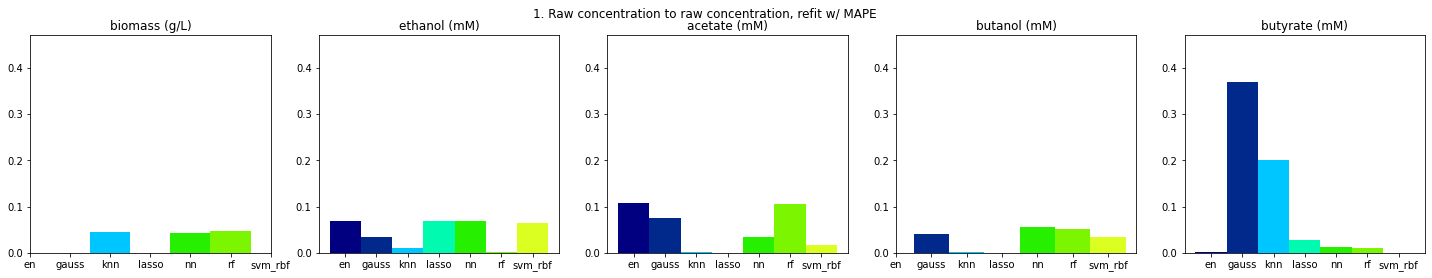

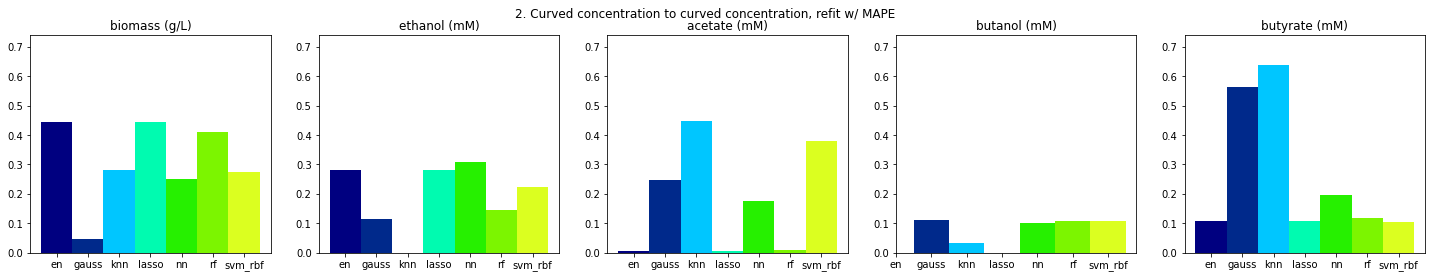

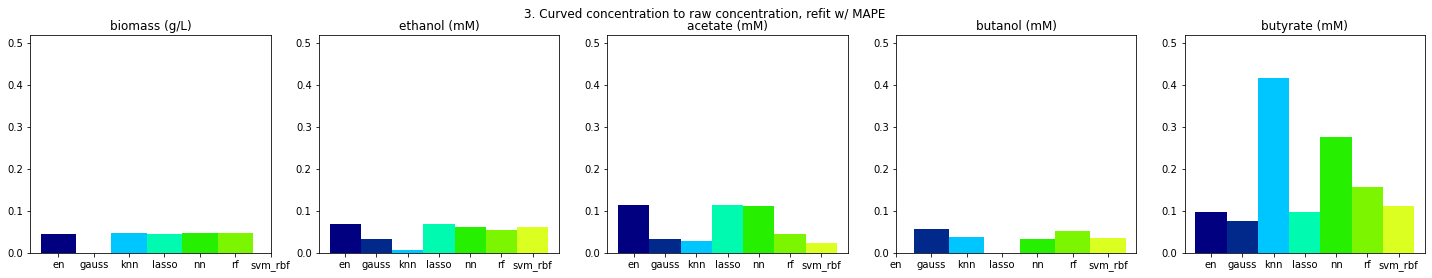

In [ ]:
plot_format = "pdf"
visual_metric = "my_cc"
refit_metric = "MAPE"
Y_columns = ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)', 'butyrate (mM)']
for i in range(3):
    if i == 0 : 
        source, target = "raw_concentration", "raw_concentration"
        plot_title = "1. Raw concentration to raw concentration, refit w/ MAPE"
    elif i == 1: 
        source, target = "curved_concentration", "curved_concentration"
        plot_title = "2. Curved concentration to curved concentration, refit w/ MAPE"
    elif i == 2:
        source, target = "curved_concentration", "raw_concentration"
        plot_title = "3. Curved concentration to raw concentration, refit w/ MAPE"
    

    result_pickle = F"result_{source}_to_{target}_{refit_metric}.pickle"
    plot_save = F"bar_{visual_metric}.{source}.{target}.{refit_metric}.{plot_format}"

    full_results = pickle.load(open(result_pickle, "br"))
    beautiful_plot(full_results, Y_columns, visual_metric, plot_title, plot_save)

### 2.1.3 Plot time course

In [ ]:
plot_format = "pdf"
metric_short = "MAPE"
source, target = "raw_concentration", "raw_concentration"
model_file = F"model_{source}_to_{target}_{metric_short}.pickle"
test_compositions = (8,9,10)
scaler_type = "minmax"

best_models = pickle.load(open(model_file, "br"))

plot_time_course(
    test_df, 
    X_columns, y_columns, test_compositions, 
    best_models, 
    metric_short, source, target, 
    plot_format
)

KeyError: ('minmax', 'biomass (g/L)', (8, 9, 10))

<Figure size 1152x1728 with 0 Axes>

## 2.2 When Refit goal is R2

### 2.2.1 Running the experiments


In [ ]:
metric = metric_short = "r2"
X_columns = ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2']
y_columns = ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)']

for i in range(1):

    # 1. raw concentration => raw concentration
    if i == 0:
        train_df = pd.read_csv(f'../data/experimental_data.csv')
        test_df  = train_df
        source, target = "raw_concentration", "raw_concentration"
    elif i==1:
        # 2. curved concentration => curved concentration 
        train_df = pd.read_csv(f'../data/rates_data.csv')
        test_df  = train_df
        source, target = "curved_concentration", "curved_concentration"

    elif i==2: 
        # 3. curved concentration => raw concentration
        train_df = pd.read_csv(f'../data/rates_data.csv')
        test_df = pd.read_csv(f'../data/experimental_data.csv')
        source, target = "curved_concentration", "raw_concentration"

    # elif i==3:
    #     # 5. curved concentration => curved rate
    #     train_df = pd.read_csv(f'../data/rates_data.csv')
    #     test_df = train_df
    #     source, target = "curved_concentration", "curved_rate"
    #     metric = 'neg_mean_absolute_percentage_error'
    #     metric_short = "MAPE"
    #     X_columns = ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2']
    #     y_columns = ['biomass rate','ethanol rate','acetate rate','butanol rate','butyrate rate']

    results_raw_concentration = complete_loop(
        train_df, test_df, test_cfgs,  X_columns , y_columns , 
        F"result_{source}_to_{target}_{metric_short}.pickle",
        F"model_{source}_to_{target}_{metric_short}.pickle",
        metric)


minmax	biomass (g/L)	(8, 9, 10)	knn	0.212	-0.175	{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 19, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	knn	0.039	0.062	{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 14, 'weights': 'distance'}
minmax	acetate (mM)	(8, 9, 10)	knn	-0.091	-0.044	{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 11, 'weights': 'distance'}
minmax	butanol (mM)	(8, 9, 10)	knn	0.238	-0.291	{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 9, 'weights': 'distance'}
minmax	butyrate (mM)	(8, 9, 10)	knn	0.697	0.050	{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 20, 'weights': 'distance'}


### 2.2.2 Visualize R2-based results

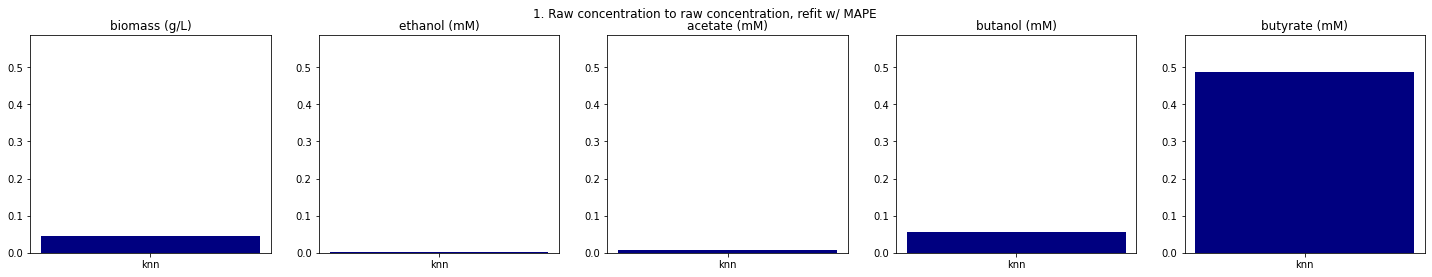

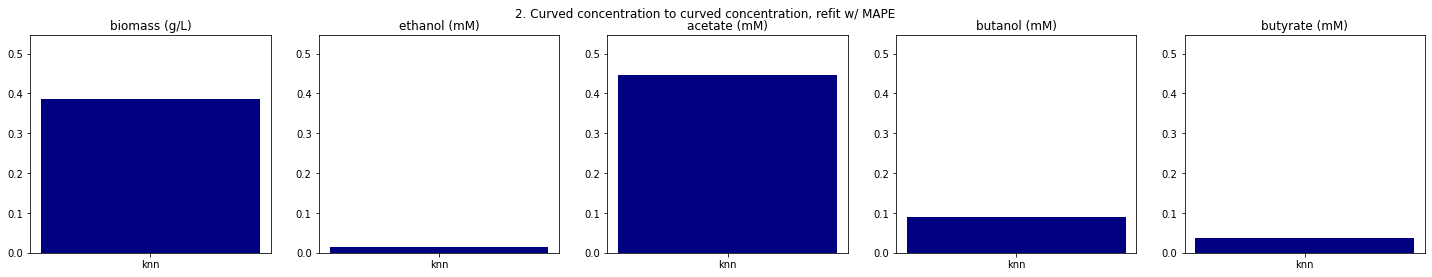

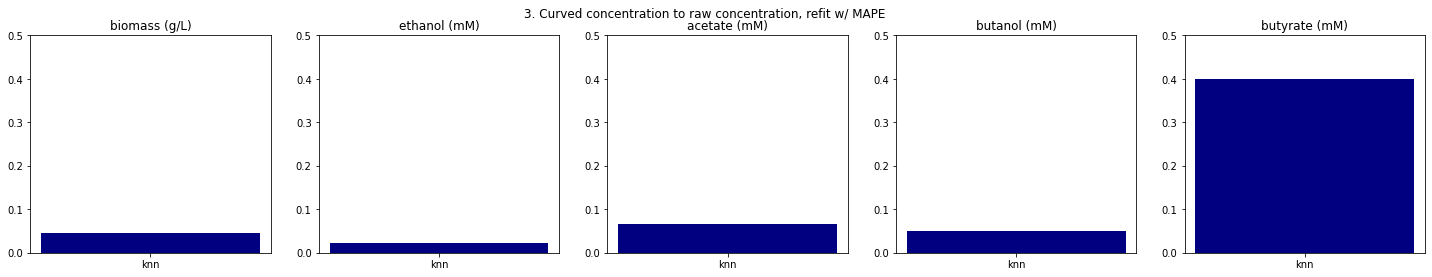

In [ ]:
plot_format = "pdf"
visual_metric = "my_cc"
refit_metric = "r2"
Y_columns = ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)', 'butyrate (mM)']
for i in range(3):
    if i == 0 : 
        source, target = "raw_concentration", "raw_concentration"
        plot_title = "1. Raw concentration to raw concentration, refit w/ MAPE"
    elif i == 1: 
        source, target = "curved_concentration", "curved_concentration"
        plot_title = "2. Curved concentration to curved concentration, refit w/ MAPE"
    elif i == 2:
        source, target = "curved_concentration", "raw_concentration"
        plot_title = "3. Curved concentration to raw concentration, refit w/ MAPE"
    

    result_pickle = F"result_{source}_to_{target}_{refit_metric}.pickle"
    plot_save = F"bar_{visual_metric}.{source}.{target}.{refit_metric}.{plot_format}"

    full_results = pickle.load(open(result_pickle, "br"))
    beautiful_plot(full_results, Y_columns, visual_metric, plot_title, plot_save)

### 2.2.3 Plot time course comparison between our prediction and groundtruth

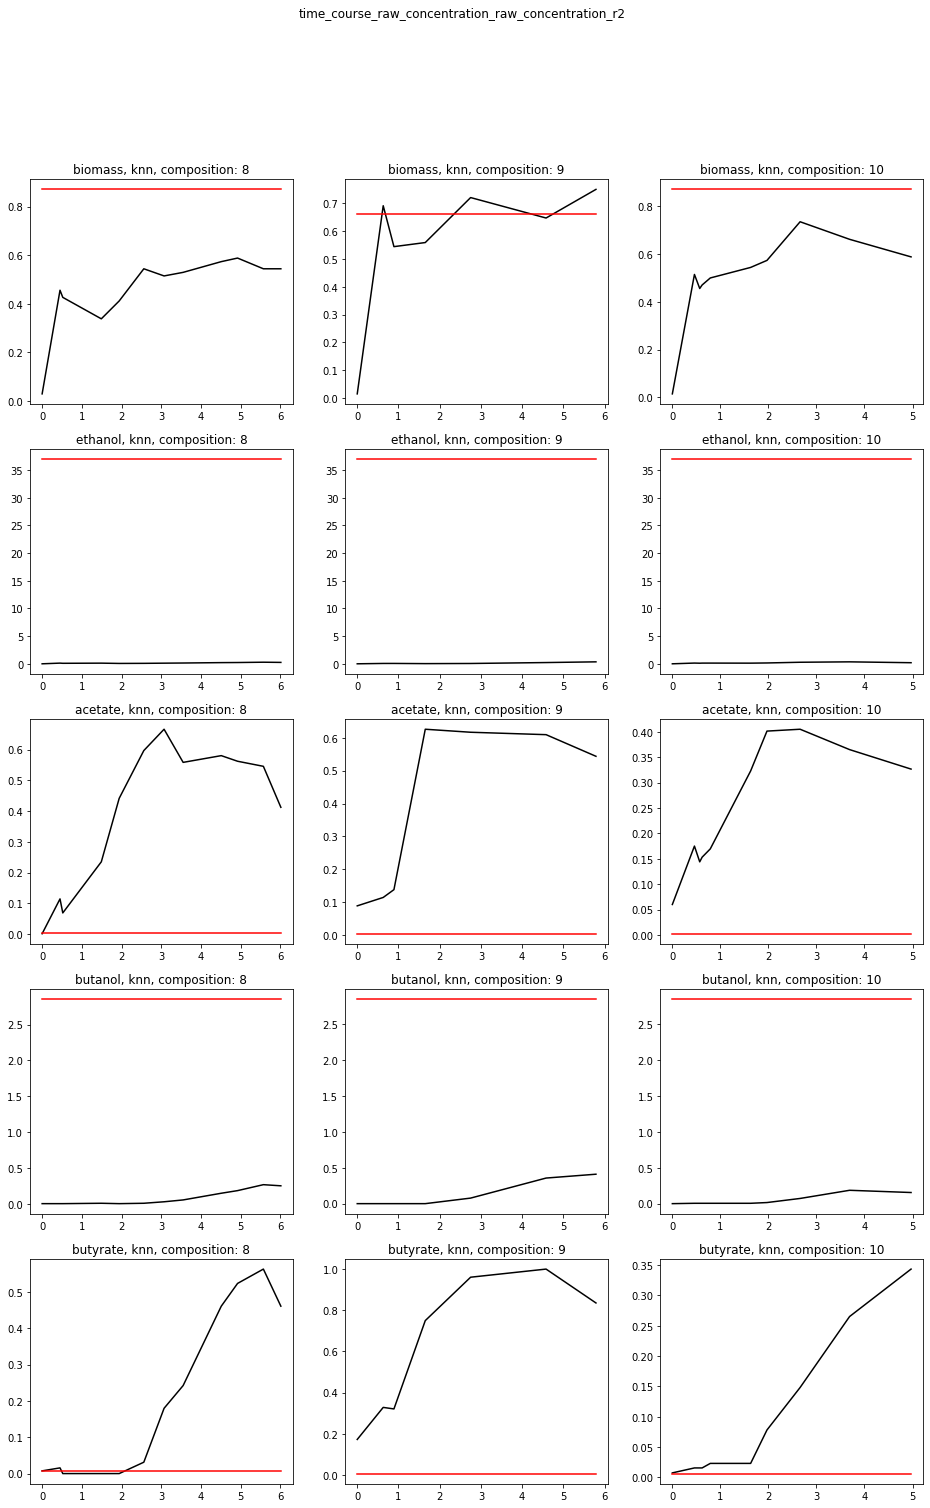

In [ ]:
plot_format = "pdf"
metric_short = "r2"
source, target = "raw_concentration", "raw_concentration"
model_file = F"model_{source}_to_{target}_{metric_short}.pickle"
test_compositions = (8,9,10)
scaler_type = "minmax"

best_models = pickle.load(open(model_file, "br"))

plot_time_course(
    test_df, 
    X_columns, y_columns, test_compositions, 
    best_models, 
    metric_short, source, target, 
    plot_format
)

In [ ]:
best_models.keys()

dict_keys([('minmax', 'biomass (g/L)', (8, 9, 10)), ('minmax', 'butyrate (mM)', (8, 9, 10))])